# 9_ctx_3region_DEGs_expression_in_cc

In [1]:
import pandas as pd
import scanpy as sc
from scipy.spatial import cKDTree
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')

/mnt/Data16Tc/home/haichao/anaconda3/envs/SpaCon_test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### gene exp data

In [3]:
adata_in = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/adata_processed.h5ad')
allen_region = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/allen_region.csv')
adata_in.obs['region'] = allen_region['region'].values
meta = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/cell_metadata_with_cluster_annotation.csv')
meta = meta.set_index('cell_label')
meta = meta.loc[adata_in.obs.index.to_list()]
adata_in.obs['cell_type'] = meta['class'].to_list()

adata_out = sc.read_h5ad('/mnt/Data18Td/Data/haichao/merfish_raw_data_zxw3/out_cell_adata/adata_out_cell_distance_q0.3/after_qc/Zhuang-ABCA-3.001.h5ad')
adata_out.obs['region'] = adata_in.obs.loc[adata_out.obs_names]['region'].values

adata_in = adata_in[adata_in.obs['cell_type'].str.contains('Glut')]
adata_out.obs

,totalRNA,brain_section_label,x,y,z,n_genes_by_counts,total_counts,region
100008170567769574864159172860058606533,175,Zhuang-ABCA-3.001,19.063883,33.423346,54.106801,100,175,MOB
100019036144713180485707288452329906643,373,Zhuang-ABCA-3.001,44.290637,63.872748,53.902462,189,373,NDB
10002377904544842423531242460024745973,277,Zhuang-ABCA-3.001,63.860525,7.998013,54.043841,126,277,RSPd2/3
100027648052649525810014127621472143070,435,Zhuang-ABCA-3.001,113.480480,41.056674,54.349928,165,435,arb
100029875144524072265954931895494067096,60,Zhuang-ABCA-3.001,11.572676,37.921554,54.370336,39,60,MOB
...,...,...,...,...,...,...,...,...
99961718914838042706216314325649765172,627,Zhuang-ABCA-3.001,113.199100,23.661374,54.096322,157,627,CENT3
9996242280180655885872867452807576494,157,Zhuang-ABCA-3.001,86.896566,18.326938,54.027272,100,157,SCop
999921392501518309214993564089572563,97,Zhuang-ABCA-3.001,21.082878,31.635078,54.090905,67,97,ORBm1
99995909784199304193294645747252265238,154,Zhuang-ABCA-3.001,111.605478,22.417974,54.070819,93,154,CENT3


In [4]:
gene_com = list(set(adata_in.var_names) & set(adata_out.var_names))
adata_in = adata_in[:, gene_com]
adata_out = adata_out[:, gene_com]

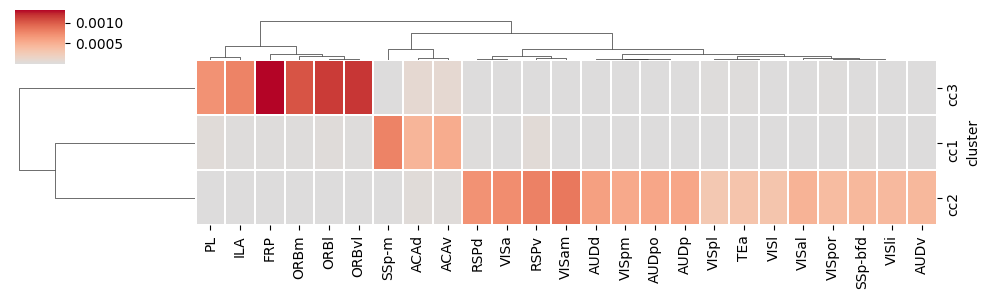

In [5]:
ctx2cc_conn_cluster_mean = pd.read_csv('./ctx_cc_conn_filtered.csv', index_col=0)
sns.clustermap(ctx2cc_conn_cluster_mean, cmap='coolwarm', center=0, figsize=(10, 3), linewidths=0.05, linecolor='white')

In [6]:
adata_ctx = adata_in[adata_in.obs['region'].str.startswith(tuple(ctx2cc_conn_cluster_mean.columns))]
adata_ctx

View of AnnData object with n_obs × n_vars = 67823 × 1111
    obs: 'brain_section_label', 'x', 'y', 'z', 'x_ccf', 'y_ccf', 'z_ccf', 'region', 'cell_type'

In [12]:

ctx1 = ['FRP', 'ORBl', 'ORBvl', 'ORBm', 'PL', 'ILA']
ctx2 = ['SSp-m', 'ACAd', 'ACAv']
ctx3=['RSPv','RSPd', 'VISpm', 'VISa', 'VISam', 'SSp-bfd', 'VISpor', 'VISli', 'TEa', 'VISpl', 'VISl', 'AUDv', 'VISal', 'AUDpo', 'AUDp', 'AUDd']
adata_ctx.obs['cc_ctx'] = None
adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx1)), 'cc_ctx'] = 'ctx1'
adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx2)), 'cc_ctx'] = 'ctx2'
adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx3)), 'cc_ctx'] = 'ctx3'
adata_ctx = adata_ctx[adata_ctx.obs['cc_ctx'].notna()]

In [ ]:
adata_cc = adata_out[adata_out.obs['region'].str.startswith('cc')]
tmp = adata_cc.copy()
idx = []
cc_cluster_by_conn = pd.read_csv('./cc_cluster_by_conn.csv', index_col=0)
coordinate = cc_cluster_by_conn[['x', 'y']].values
kdtree = cKDTree(coordinate)
for coord in tqdm(adata_cc.obs[['x', 'y']].values):
    # 查询最近邻索引
    _, nearest_index = kdtree.query(coord)
    idx.append(nearest_index)
plt.figure(figsize=(9,5))
### match the cc cluster
adata_cc.obs['NT_index'] = idx
adata_cc.obs['cc'] = cc_cluster_by_conn.loc[adata_cc.obs['NT_index']]['c'].values
adata_cc = adata_cc[adata_cc.obs['cc'].notna()]
adata_cc.obs['cc'] = 'cc'+((adata_cc.obs['cc']).astype(int)+1).astype(str)
#### plot
categories = adata_cc.obs['cc'].unique()
# plt.scatter(adata_out.obs['x'], adata_out.obs['y'], s=1, c='#d3d3d3')
plt.scatter(tmp.obs['x'], tmp.obs['y'], s=20, c='#8f8f8f')
# plt.scatter(tmp.obs['x'], tmp.obs['y'], s=20, c='#d3d3d3')

# 为每个类别绘制散点
cm = ['#ff7f0e', '#2ca02c', '#2377b4']
# cm = ['#6597b9', '#6bad6b', '#e9a161']
i=0
for category in categories:
    subset = adata_cc[adata_cc.obs['cc'] == category]
    plt.scatter(subset.obs['x'], subset.obs['y'], label=category, s=20, c=cm[i])
    # print(f'cc_{int(category)}')
    i=i+1
plt.legend()
plt.gca().invert_yaxis()
# plt.savefig('cc_area.png', dpi=600)
# plt.savefig('./cc/cc1_cc2_cc3.pdf', format='pdf')

#### DEG

In [14]:
sc.pp.normalize_total(adata_ctx, target_sum=1e4)
sc.pp.log1p(adata_ctx)

In [15]:
sc.pp.normalize_total(adata_cc, target_sum=1e4)
sc.pp.log1p(adata_cc)

In [16]:
sc.tl.rank_genes_groups(adata_ctx, groupby="cc_ctx", reference="rest", n_genes=adata_ctx.shape[1], method='wilcoxon')

In [17]:
regions = adata_ctx.obs['cc_ctx'].unique()
top_genes_df = pd.DataFrame(columns=['region', 'gene', 'score', 'logfoldchanges', 'pvals', 'pvals_adj'])
# 遍历每个区域，提取排名前3的基因
for region in regions:
    # 提取特定区域的marker基因
    markers_df = sc.get.rank_genes_groups_df(adata_ctx, group=region)
    markers_df = markers_df.sort_values(by='logfoldchanges', ascending=False)
    # 获取排名前3的基因
    top_genes = markers_df.head(5)
    # if top_genes['names'].values == 'Ttr':
    #     top_genes = markers_df.head(2)
    # 添加区域信息
    top_genes['region'] = region
    # 选择需要的列
    top_genes = top_genes[['region', 'names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']]
    # 重命名列
    top_genes.columns = ['region', 'gene', 'score', 'logfoldchanges', 'pvals', 'pvals_adj']
    # 将结果添加到汇总的DataFrame中
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)
top_genes_df = top_genes_df.set_index('region')
top_genes_df

,gene,score,logfoldchanges,pvals,pvals_adj
region,,,,,
ctx3,Nr2f2,10.998008,2.251740,3.906658e-28,2.346106e-27
ctx3,Tshz2,42.789413,1.908488,0.000000e+00,0.000000e+00
ctx3,Met,15.654150,1.551293,3.112418e-55,2.659920e-54
ctx3,Ctxn3,5.829773,1.497417,5.550263e-09,1.995580e-08
ctx3,C1ql2,4.970668,1.410147,6.672248e-07,2.193156e-06
ctx2,Scn4b,33.871655,1.264914,1.742216e-251,6.452006e-249
ctx2,Bmpr1b,13.590011,1.168321,4.590144e-42,8.792501e-41
ctx2,Adgrl2,57.814980,1.156904,0.000000e+00,0.000000e+00
ctx2,Blnk,15.697517,1.049282,1.572777e-55,5.139282e-54


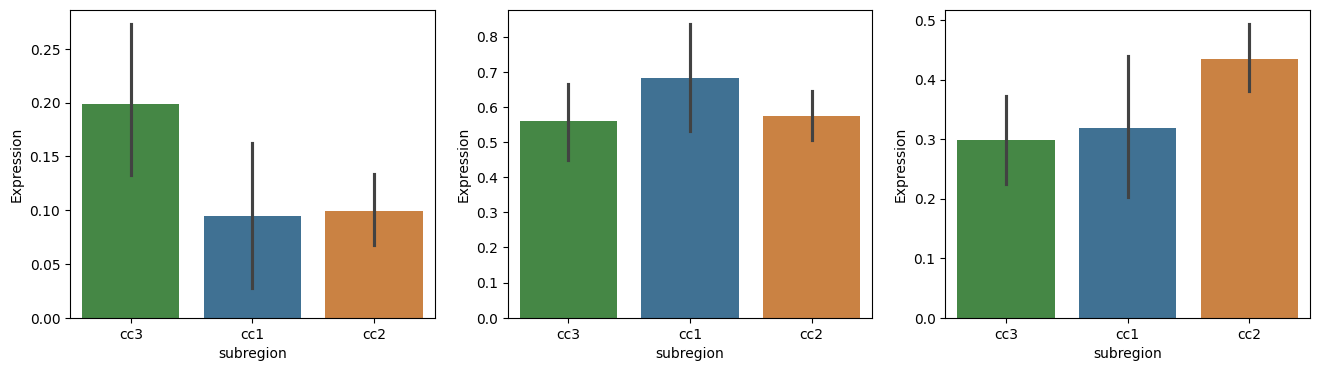

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
# top_genes_df_filt = top_genes_df[top_genes_df['logfoldchanges'] > 1]
cc = ['ctx1', 'ctx2', 'ctx3']
for i, cc_area in enumerate(cc):
    gene_data = adata_cc[:, top_genes_df.loc[cc_area]['gene']].X.A.mean(axis=1)
    group_data = adata_cc.obs['cc']
    # 创建一个DataFrame来存储这些数据
    df = pd.DataFrame({
        'Expression': gene_data,
        'subregion': group_data
    })
    ax = axes[i]
    sns.barplot(x='subregion', y='Expression', data=df, ax = ax, palette=['#3a923a', '#3274a1', '#e1812c'], order=['cc3', 'cc1', 'cc2'])